In [1]:
import pickle as pkl
from scipy.special import softmax
import numpy as np
import scipy.stats
from pathlib import Path
import calibration as cal
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import entropy
from tqdm import tqdm
import os

plt.style.use('seaborn-v0_8')
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
import warnings
warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [3]:
def train_test_split(X, y, test_size=0.2, random_state=42):
    """
    Splits data matrix X and label vector y into training and testing sets.
    
    Parameters:
    - X: np.ndarray, shape (m, n), the data matrix.
    - y: np.ndarray, shape (m,), the labels.
    - test_size: float, fraction of data to be used as test set (default is 0.2).
    - random_state: int or None, seed for reproducibility.
    
    Returns:
    - X_train: np.ndarray, training data.
    - X_test: np.ndarray, testing data.
    - y_train: np.ndarray, training labels.
    - y_test: np.ndarray, testing labels.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    m = X.shape[0]
    indices = np.arange(m)
    np.random.shuffle(indices)
    
    test_count = int(np.floor(test_size * m))
    test_indices = indices[:test_count]
    train_indices = indices[test_count:]
    
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test


def train_test_split_three_way(X, z, y, test_size=0.2, random_state=42):
    """
    Splits data matrix X and label vector y into training and testing sets.
    
    Parameters:
    - X: np.ndarray, shape (m, n), the data matrix.
    - y: np.ndarray, shape (m,), the labels.
    - test_size: float, fraction of data to be used as test set (default is 0.2).
    - random_state: int or None, seed for reproducibility.
    
    Returns:
    - X_train: np.ndarray, training data.
    - X_test: np.ndarray, testing data.
    - y_train: np.ndarray, training labels.
    - y_test: np.ndarray, testing labels.
    """
    if random_state is not None:
        np.random.seed(random_state)
    
    m = X.shape[0]
    indices = np.arange(m)
    np.random.shuffle(indices)
    
    test_count = int(np.floor(test_size * m))
    test_indices = indices[:test_count]
    train_indices = indices[test_count:]
    
    X_train, X_test = X[train_indices], X[test_indices]
    z_train, z_test = z[train_indices], z[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, z_train, z_test, y_train, y_test

In [4]:
def get_ece(conf, labels, n_bins=15):
    ece = cal.lower_bound_scaling_ce(conf, labels, p=1, debias=False, num_bins=n_bins, binning_scheme=cal.get_equal_bins, mode='top-label')
    return ece


def get_base_data(task_name, model_type, data_save_dir, top_n_steps=10):

    with open(f"{data_save_dir}/episode_data_true_prompt.pkl", "rb") as f:  # "rb" = read binary mode
        data = pkl.load(f)

    all_probs = []
    all_logits = []
    correct = []

    for episode in data:

        steps = episode["steps"]

        episode_probs = []
        episode_logits = []

        for step in steps[:top_n_steps]:


            logits = step["logits"]

            probs = softmax(logits, -1)

            episode_probs.append(probs)
            episode_logits.append(logits)

        episode_probs = np.stack(episode_probs)
        episode_logits = np.stack(episode_logits)

        all_probs.append(episode_probs)
        all_logits.append(episode_logits)

        correct.append(int(episode["done"]))

    all_probs = np.stack(all_probs)
    all_logits = np.stack(all_logits)
    correct = np.array(correct)

    print("assert", all_logits.shape, all_probs.shape)

    assert all_logits.shape == all_probs.shape

    return all_probs, all_logits, correct


def get_data(
        task_name, 
        model_type="openvla",
        quant=None,
        alternate_set=1, 
        top_n_steps=3, 
        n_prompts=20, 
        n_cal_bins=12,
):
    
    exp_data_save_str = f"../data/scaling_exp_{task_name}"
    if quant is not None:
        exp_data_save_str += f"_{quant}"
    exp_data_save_str += ".pkl"

    path = Path(exp_data_save_str).expanduser().resolve()
    verbose=True

    if path.is_file():
        if verbose:
            print(f"[load_or_create_pickle] Loading existing pickle: {path}")
        with path.open("rb") as f:
            output_data = pkl.load(f)
        
    else:

        print("Building data...", exp_data_save_str)
        
        data_save_dir = f"/local/zemel/tom/code/vla_uq/results/libero_{task_name}"
        if quant is not None:
            data_save_dir += f"/{quant}"

        base_probs, base_logits, correct = get_base_data(task_name, model_type, data_save_dir, top_n_steps)

        base_probs = np.expand_dims(base_probs, axis=2)
        base_logits = np.expand_dims(base_logits, axis=2)

        assert base_probs.shape == base_logits.shape
        
        print("Data shapes:")
        print("Probs:", base_probs.shape)
        print("Logits", base_logits.shape)
        print("Correctness", correct.shape)
        print()
        print("Accuracy:", np.mean(correct))

        by_dim_results = {"baseline":[],"ensemble":[]}

        x = base_probs[:,0,0]
        x = np.max(x, -1)

        # print("--------\nBaseline")
        for i in range(x.shape[-1]):
            dim_ece = get_ece(x[:,i], correct, n_cal_bins)
            # print(f"Dimension {i} ECE: {dim_ece}")
            by_dim_results["baseline"].append(dim_ece)
        all_ece = get_ece(np.mean(x, -1), correct, n_cal_bins)
        # print("Averaged:", all_ece)

        all_probs = []
        all_logits = []

        for i in range(n_prompts):

            prompt_probs = []
            prompt_logits = []

            if alternate_set == 1:
                data_save_str = f"{data_save_dir}/episode_data_prompt_{i}.pkl"
            elif alternate_set == 2:
                data_save_str = f"{data_save_dir}/episode_data_prompt_{i}_v2.pkl"
            elif alternate_set == 3:
                data_save_str = f"{data_save_dir}/episode_data_prompt_{i}_v3.pkl"
            else:
                raise ValueError

            with open(data_save_str, "rb") as f:  # "rb" = read binary mode
                data = pkl.load(f)

            for episode in data:

                episode_probs = []
                episode_logits = []

                steps = episode["steps"]

                for step in steps[:top_n_steps]:

                    logits = step["logits"]
                    probs = softmax(logits, -1)

                    episode_probs.append(probs)
                    episode_logits.append(logits)
                    

                episode_probs = np.stack(episode_probs)
                episode_logits = np.stack(episode_logits)
                

                # print(i, episode["task_id"], episode["episode_idx"], episode_probs.shape, episode_actions.shape)

                prompt_probs.append(episode_probs)
                prompt_logits.append(episode_logits)
                

            prompt_probs = np.stack(prompt_probs)
            prompt_logits = np.stack(prompt_logits)
            

            all_probs.append(prompt_probs)
            all_logits.append(prompt_logits)
            
        all_probs = np.stack(all_probs)
        all_probs = np.transpose(all_probs, (1,2,0,3,4))

        all_logits = np.stack(all_logits)
        all_logits = np.transpose(all_logits, (1,2,0,3,4))

        assert all_probs.shape == all_logits.shape

        ens_probs = all_probs
        ens_logits = all_logits

        x = all_probs[:,0]
        x = np.max(x, -1)
        x = np.mean(x, 1)
        # print("--------\nEnsemble")
        for i in range(x.shape[-1]):
            dim_ece = get_ece(x[:,i], correct, n_cal_bins)
            # print(f"Dimension {i} ECE: {dim_ece}")
            by_dim_results["ensemble"].append(dim_ece)
        all_ece = get_ece(np.mean(x, -1), correct, n_cal_bins)
        # print("Averaged:", all_ece)

        # base_conf = np.mean(np.max(base_probs, -1), -2)[:,0]
        # ens_conf = np.mean(np.max(all_probs, -1), -2)[:,0]

        # print("base conf shape", base_conf.shape)
        # print("ens conf shape", ens_conf.shape)

        output_data = (base_probs, ens_probs, base_logits, ens_logits, correct, by_dim_results)


        with open(exp_data_save_str, "wb") as f:
            pkl.dump(output_data, f)

    return output_data


In [5]:
class PlattScaler:
    def __init__(self, max_iter=100, tol=1e-5):
        """
        Initializes the PlattScaler.
        
        Parameters:
        - max_iter: Maximum number of iterations for the optimizer.
        - tol: Tolerance for the convergence criterion.
        """
        self.max_iter = max_iter
        self.tol = tol
        self.A = None
        self.B = None

    def _sigmoid(self, x):
        """Compute the sigmoid function."""
        return 1 / (1 + np.exp(-x))

    def fit(self, probabilities, correctness):
        """
        Fit the Platt scaling model.
        
        Parameters:
        - probabilities: list or array of unscaled probabilities (or scores), shape (n,).
        - correctness: list or array of binary outcomes (0 or 1) indicating correctness, shape (n,).
        
        Returns:
        - self: fitted PlattScaler instance.
        """
        X = np.array(probabilities)
        y = np.array(correctness)
        
        def objective(params):
            A, B = params
            p = self._sigmoid(A * X + B)
            eps = 1e-6
            p = np.clip(p, eps, 1 - eps)
            return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
        
        def grad(params):
            A, B = params
            p = self._sigmoid(A * X + B)
            error = p - y
            grad_A = np.sum(error * X)
            grad_B = np.sum(error)
            return np.array([grad_A, grad_B])
        
        result = minimize(
            objective,
            x0=[1.0, 0.0],
            jac=grad,
            method='BFGS',
            options={'maxiter': self.max_iter, 'gtol': self.tol}
        )
        
        self.A, self.B = result.x
        return self

    def predict(self, probabilities):
        """
        Predict calibrated probabilities.
        
        Parameters:
        - probabilities: list or array of unscaled probabilities, shape (n,).
        
        Returns:
        - calibrated: numpy array of calibrated probabilities, shape (n,).
        """
        if self.A is None or self.B is None:
            raise ValueError("The model has not been fitted yet. Call 'fit' first.")
        
        X = np.array(probabilities)
        calibrated = self._sigmoid(self.A * X + self.B)
        return calibrated

class ActionPlattScaler:
    def __init__(self, max_iter=100, tol=1e-5, combine_method="product"):
        """
        Initializes the ActionPlattScaler.
        
        Parameters:
        - max_iter: Maximum number of iterations for each underlying PlattScaler.
        - tol: Tolerance for convergence of the optimizer.
        - combine_method: How to combine calibrated probabilities from each dimension.
                          Options include "product" (default), "mean", or "weighted".
                          "weighted" learns a logistic regression combiner.
        """
        self.max_iter = max_iter
        self.tol = tol
        self.combine_method = combine_method
        self.scalers = []  # One PlattScaler per action dimension
        self.combiner = None  # Parameters for logistic regression combiner, if used

    def fit(self, action_probabilities, correctness):
        """
        Fit the ActionPlattScaler on a matrix of raw probabilities and a single correctness vector.
        
        Parameters:
        - action_probabilities: m×a matrix where each column corresponds to a different action dimension.
        - correctness: m-dimensional vector of binary outcomes (0 or 1) indicating overall correctness.
        
        Returns:
        - self: fitted ActionPlattScaler instance.
        """
        X = np.array(action_probabilities)
        y = np.array(correctness)
        
        if X.shape[0] != y.shape[0]:
            raise ValueError("The number of examples in action_probabilities and correctness must match.")
        
        num_actions = X.shape[1]
        self.scalers = []
        
        # Train a separate PlattScaler for each action dimension using the same correctness labels.
        for i in range(num_actions):
            scaler = PlattScaler(max_iter=self.max_iter, tol=self.tol)
            scaler.fit(X[:, i], y)
            self.scalers.append(scaler)
        
        # If using the weighted combination, train a logistic regression combiner.
        if self.combine_method == "weighted":
            # First, compute calibrated probabilities for each action dimension on training data.
            calibrated_features = np.zeros_like(X, dtype=float)
            for i, scaler in enumerate(self.scalers):
                calibrated_features[:, i] = scaler.predict(X[:, i])
            
            # Define the logistic regression model on the calibrated features.
            # Model: sigma(w^T f + b), where f is the calibrated feature vector.
            def combiner_objective(params):
                w = params[:-1]
                b = params[-1]
                logits = np.dot(calibrated_features, w) + b
                p = 1 / (1 + np.exp(-logits))
                eps = 1e-6
                p = np.clip(p, eps, 1 - eps)
                return -np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))
            
            def combiner_grad(params):
                w = params[:-1]
                b = params[-1]
                logits = np.dot(calibrated_features, w) + b
                p = 1 / (1 + np.exp(-logits))
                error = p - y
                grad_w = np.dot(calibrated_features.T, error)
                grad_b = np.sum(error)
                return np.concatenate([grad_w, [grad_b]])
            
            # Initialize combiner parameters: one weight per dimension and one bias.
            init_params = np.zeros(num_actions + 1)
            result = minimize(
                combiner_objective,
                x0=init_params,
                jac=combiner_grad,
                method='BFGS',
                options={'maxiter': self.max_iter, 'gtol': self.tol}
            )
            self.combiner = result.x
        
        return self

    def predict(self, action_probabilities):
        """
        Predict a combined calibrated probability for each example.
        
        Parameters:
        - action_probabilities: s×a matrix of raw probabilities for each action dimension.
        
        Returns:
        - combined: numpy array of combined calibrated probabilities, shape (s,).
        """
        X = np.array(action_probabilities)
        s, num_actions = X.shape
        
        if num_actions != len(self.scalers):
            raise ValueError("Mismatch between number of action dimensions and trained scalers.")
        
        # Calibrate each action dimension independently.
        calibrated = np.zeros((s, num_actions))
        for i, scaler in enumerate(self.scalers):
            calibrated[:, i] = scaler.predict(X[:, i])
        
        if self.combine_method == "product":
            combined = np.prod(calibrated, axis=1)
        elif self.combine_method == "mean":
            combined = np.mean(calibrated, axis=1)
        elif self.combine_method == "weighted":
            if self.combiner is None:
                raise ValueError("Combiner has not been trained. Call 'fit' first.")
            w = self.combiner[:-1]
            b = self.combiner[-1]
            logits = np.dot(calibrated, w) + b
            combined = 1 / (1 + np.exp(-logits))
        else:
            raise ValueError("Unsupported combine_method. Use 'product', 'mean', or 'weighted'.")
        
        return combined



In [6]:
def recal_experiment(
    action_conf, 
    action_logits,
    correct, 
    test_size=0.4,
    n_trials = 100,
    n_cal_bins = 10
):
    
    uncal_eces = []
    recal_eces = []
    action_recal_eces = []
    temp_scale_eces = []
    action_temp_scale_eces = []
    
    for trial_no in tqdm(range(n_trials)):

        conf_train, conf_test, logits_train, logits_test, correct_train, correct_test \
              = train_test_split_three_way(action_conf, action_logits, correct, test_size=test_size, random_state=trial_no)
        
        mean_train_conf = np.mean(conf_train, -1)
        mean_test_conf = np.mean(conf_test, -1)

        uncal_ece = round(get_ece(mean_test_conf, correct_test, n_cal_bins), 3)

        scaler = PlattScaler(max_iter=200, tol=1e-6)
        scaler.fit(mean_train_conf, correct_train)

        calibrated_probs = scaler.predict(mean_test_conf)

        recal_ece = round(get_ece(calibrated_probs, correct_test, n_cal_bins), 3)

        action_scaler = ActionPlattScaler(max_iter=200, tol=1e-8, combine_method="mean")
        action_scaler.fit(conf_train, correct_train)

        calibrated_probs = action_scaler.predict(conf_test)

        action_recal_ece = round(get_ece(calibrated_probs, correct_test, n_cal_bins), 3)


        # print(logits_test.shape, logits_train.shape)

        # print("Plain")

        temp_scaler = TempScaler()
        temp_scaler.set_temperature(torch.Tensor(logits_train), torch.FloatTensor(correct_train))
        temp_scaler.eval()
        with torch.no_grad():
            scaled_test_conf = temp_scaler.temperature_scale(torch.Tensor(logits_test).cuda()).cpu().numpy()
        temp_scale_ece = round(get_ece(scaled_test_conf, correct_test, n_cal_bins), 3)

        # print("Action-wise")

        action_temp_scaler = ActionTempScaler()
        action_temp_scaler.set_temperature(torch.Tensor(logits_train), torch.FloatTensor(correct_train))
        action_temp_scaler.eval()
        with torch.no_grad():
            action_scaled_test_conf = action_temp_scaler.temperature_scale(torch.Tensor(logits_test).cuda()).cpu().numpy()
        action_temp_scale_ece = round(get_ece(action_scaled_test_conf, correct_test, n_cal_bins), 3)

        # print("Doned")

        uncal_eces.append(uncal_ece)
        recal_eces.append(recal_ece)
        action_recal_eces.append(action_recal_ece)

        temp_scale_eces.append(temp_scale_ece)
        action_temp_scale_eces.append(action_temp_scale_ece)
        

    print(f"uncal ece: {np.mean(uncal_eces)} | recal ece: {np.mean(recal_eces)} | action recal ece: {np.mean(action_recal_eces)}")
    print(f"temp scale ece: {np.mean(temp_scale_eces)} | action temp scale ece: {np.mean(action_temp_scale_eces)}")
    return {
        "uncal_ece": np.mean(uncal_eces), "recal_ece": np.mean(recal_eces), "action_recal_ece": np.mean(action_recal_eces),
        "temp_scale_ece": np.mean(temp_scale_eces), "action_temp_scale_ece": np.mean(action_temp_scale_eces),
        "recal_ece_std": np.std(recal_eces), "action_recal_ece_std": np.std(action_recal_eces),
        "temp_scale_std": np.std(temp_scale_eces), "action_temp_scale_std": np.std(action_temp_scale_eces)
        }



import torch
from torch import nn, optim
from torch.nn import functional as F


class TempScaler(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self):
        super(TempScaler, self).__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)


    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        # print("temp scale logits", logits.shape)
        temperature = self.temperature.view(1,1,1)
        out = logits / temperature
        # print("out 1", out.shape)
        out = out.softmax(-1)
        # print("out 2", out.shape)
        out = torch.max(out, -1)[0]
        # print("out 3", out.shape)
        out = torch.mean(out, -1)
        return out



    # This function probably should live outside of this class, but whatever
    def set_temperature(self, logits, labels):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.BCELoss().cuda()

        logits = logits.cuda()
        labels = labels.cuda()

        # print("set temperature", logits.shape, labels.shape)

        scaled_logits = self.temperature_scale(logits)
        # print("scaled", scaled_logits.shape)
        # print("labels", labels.shape)

        # e += 7

        # print("Calculate NLL and ECE before temperature scaling")
        before_temperature_nll = nll_criterion(scaled_logits, labels).item()
        # before_temperature_ece = ece_criterion(logits, labels).item()
        # print('Before temperature - NLL: %.3f' % (before_temperature_nll))

        # e += 7

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.01, max_iter=50)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        # after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        # print('Optimal temperature: %.3f' % self.temperature.item())
        # print('After temperature - NLL: %.3f' % (after_temperature_nll))

        return self



class ActionTempScaler(nn.Module):
    """
    A thin decorator, which wraps a model with temperature scaling
    model (nn.Module):
        A classification neural network
        NB: Output of the neural network should be the classification logits,
            NOT the softmax (or log softmax)!
    """
    def __init__(self):
        super(ActionTempScaler, self).__init__()
        self.temperature = nn.Parameter(torch.ones(7) * 1.5)


    def temperature_scale(self, logits):
        """
        Perform temperature scaling on logits
        """
        # Expand temperature to match the size of logits
        # print("temp scale logits", logits.shape)
        temperature = self.temperature.view(1,7,1)
        out = logits / temperature
        # print("out 1", out.shape)
        out = out.softmax(-1)
        # print("out 2", out.shape)
        out = torch.max(out, -1)[0]
        # print("out 3", out.shape)
        out = torch.mean(out, -1)
        return out



    # This function probably should live outside of this class, but whatever
    def set_temperature(self, logits, labels):
        """
        Tune the tempearature of the model (using the validation set).
        We're going to set it to optimize NLL.
        valid_loader (DataLoader): validation set loader
        """
        self.cuda()
        nll_criterion = nn.BCELoss().cuda()

        logits = logits.cuda()
        labels = labels.cuda()

        scaled_logits = self.temperature_scale(logits)

        # print("Calculate NLL and ECE before action temperature scaling")
        before_temperature_nll = nll_criterion(scaled_logits, labels).item()
        # before_temperature_ece = ece_criterion(logits, labels).item()
        # print('Before action temperature - NLL: %.3f' % (before_temperature_nll))

        # Next: optimize the temperature w.r.t. NLL
        optimizer = optim.LBFGS([self.temperature], lr=0.0001, max_iter=500)

        def eval():
            optimizer.zero_grad()
            loss = nll_criterion(self.temperature_scale(logits), labels)
            loss.backward()
            return loss
        optimizer.step(eval)

        # Calculate NLL and ECE after temperature scaling
        after_temperature_nll = nll_criterion(self.temperature_scale(logits), labels).item()
        # after_temperature_ece = ece_criterion(self.temperature_scale(logits), labels).item()
        # print('Optimal action-wise temperature', self.temperature)
        # print('After action temperature - NLL: %.3f' % (after_temperature_nll))

        return self



In [7]:
def run_exp(task_name, quant, n_bins=12, test_size=0.8, n_prompts=20, n_trials=1000, alternate_set=1):

    print("--------"*4)
    print(quant)
    print("--------"*4)

    base_probs, ens_probs, base_logits, ens_logits, correct, by_dim_results = get_data(
        task_name, 
        alternate_set=alternate_set, 
        n_prompts=n_prompts,
        quant=quant,
    )

    base_conf = np.mean(np.max(base_probs, -1), -2)[:,0]
    ens_conf = np.mean(np.max(ens_probs, -1), -2)[:,0]

    print("base_conf", base_conf.shape)
    print("base_probs", base_probs.shape)
    print("base_logits", base_logits.shape)
    print("ens_conf", ens_conf.shape)
    print("ens_probs", ens_probs.shape)
    print("ens_logits", ens_logits.shape)

    mean_base_conf = np.mean(base_conf, -1)
    mean_ens_conf = np.mean(ens_conf, -1)

    base_ece = round(get_ece(mean_base_conf, correct, n_bins), 3)
    ens_ece = round(get_ece(mean_ens_conf, correct, n_bins), 3)

    print("---------------------\nBase Recalibration")
    baseline_results = recal_experiment(
        base_conf, 
        base_logits[:,0,0],
        correct, 
        test_size=test_size,
        n_trials=n_trials,
        n_cal_bins=n_bins,
    )
    print(baseline_results)

    bar_colors = pal[1:4]
    scale_factor = 1.25

    fig, axs = plt.subplots(1,2, figsize=(10, 3.25), width_ratios=[0.45,0.55])

    scores = by_dim_results["baseline"]
    X = np.arange(len(scores))
    axs[0].bar(X, scores)
    labels = [f"{i+1}" for i in range(len(by_dim_results["baseline"]))]
    axs[0].set_xticks(X, labels, fontsize=15)
    axs[0].set_xlabel("Action Dimension", fontsize=18)

    # scores = [ensemble_results["uncal_ece"], ensemble_results["recal_ece"], ensemble_results["action_recal_ece"]]
    # labels = ["Uncal.","Platt\nScaling","Action\nScaling"]
    scores = [baseline_results["temp_scale_ece"], baseline_results["recal_ece"], baseline_results["action_recal_ece"]]
    stds = [baseline_results["temp_scale_std"], baseline_results["recal_ece_std"], baseline_results["action_recal_ece_std"]]
    labels = ["Temp\nScaling","Platt\nScaling","Action-Wise\nPlatt Scaling"]
    X = np.arange(len(scores))
    # axs[1].bar(X, scores, color=bar_colors)
    axs[1].bar(X, scores, color=bar_colors, yerr=stds/np.sqrt(n_trials), error_kw=dict(ecolor='dimgrey', lw=2, capsize=3, capthick=2))
    # axs[1].errorbar(X, scores, stds)
    axs[1].set_xticks(X, labels, fontsize=15)

    for i in range(2):
        axs[i].set_ylabel(r"$\text{ECE}_1$", fontsize=18)
        axs[i].tick_params(axis="y", labelsize=13)

    if quant is not None:
        quant_tag = f" ({quant})"
    else:
        quant_tag = ""

    axs[1].set_ylim(min(baseline_results["recal_ece"], baseline_results["action_recal_ece"])/scale_factor, None)

    fig.suptitle(f"{str.title(task_name)}{str.title(quant_tag)}", fontsize=18, y=0.95)
    fig.tight_layout()

    quant_save_string = quant_tag.replace("(","").replace(")","").strip()

    plt.savefig(f"../plots/action_scaling_{task_name}_{quant_save_string}_baseline_w_temp_scaling.png", dpi=600, bbox_inches="tight")
    plt.show()


--------------------------------
None
--------------------------------
[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_uq/data/scaling_exp_spatial.pkl
base_conf (500, 7)
base_probs (500, 3, 1, 7, 256)
base_logits (500, 3, 1, 7, 256)
ens_conf (500, 7)
ens_probs (500, 3, 20, 7, 256)
ens_logits (500, 3, 20, 7, 256)
---------------------
Base Recalibration


100%|██████████| 1000/1000 [07:22<00:00,  2.26it/s]


uncal ece: 0.08401299999999999 | recal ece: 0.062754 | action recal ece: 0.057471
temp scale ece: 0.07641399999999998 | action temp scale ece: 0.07434799999999998
{'uncal_ece': 0.08401299999999999, 'recal_ece': 0.062754, 'action_recal_ece': 0.057471, 'temp_scale_ece': 0.07641399999999998, 'action_temp_scale_ece': 0.07434799999999998, 'recal_ece_std': 0.020298361608760446, 'action_recal_ece_std': 0.017768769203295988, 'temp_scale_std': 0.00812789050123093, 'action_temp_scale_std': 0.008115349407142}


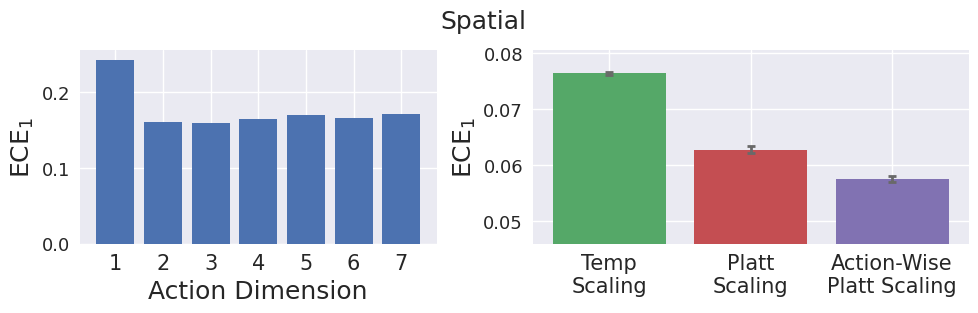

--------------------------------
None
--------------------------------
[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_uq/data/scaling_exp_goal.pkl
base_conf (500, 7)
base_probs (500, 3, 1, 7, 256)
base_logits (500, 3, 1, 7, 256)
ens_conf (500, 7)
ens_probs (500, 3, 20, 7, 256)
ens_logits (500, 3, 20, 7, 256)
---------------------
Base Recalibration


100%|██████████| 1000/1000 [11:22<00:00,  1.46it/s]


uncal ece: 0.147684 | recal ece: 0.079785 | action recal ece: 0.065087
temp scale ece: 0.119566 | action temp scale ece: 0.11691300000000002
{'uncal_ece': 0.147684, 'recal_ece': 0.079785, 'action_recal_ece': 0.065087, 'temp_scale_ece': 0.119566, 'action_temp_scale_ece': 0.11691300000000002, 'recal_ece_std': 0.01950155827107157, 'action_recal_ece_std': 0.019135397330601735, 'temp_scale_std': 0.00956376724936361, 'action_temp_scale_std': 0.008959544129027995}


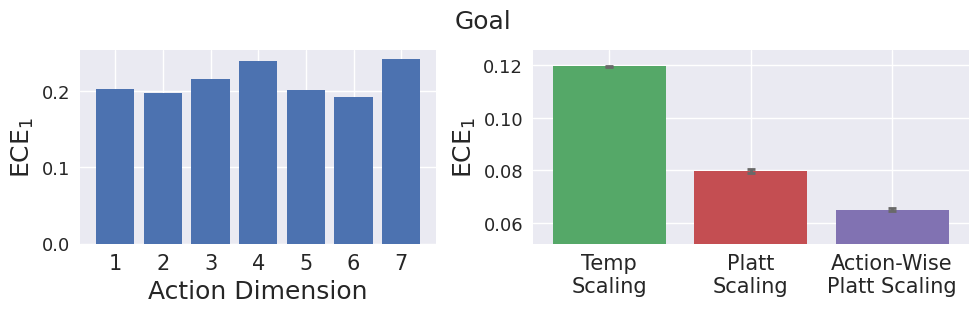

In [8]:
n_bins = 10
test_size = 0.8
n_trials = 1000 


run_exp("spatial", quant=None, n_bins=n_bins, test_size=test_size, n_trials=n_trials)
run_exp("goal", quant=None, n_bins=n_bins, test_size=test_size, n_trials=n_trials)


--------------------------------
quant8
--------------------------------
[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_uq/data/scaling_exp_spatial_quant8.pkl
base_conf (500, 7)
base_probs (500, 3, 1, 7, 256)
base_logits (500, 3, 1, 7, 256)
ens_conf (500, 7)
ens_probs (500, 3, 20, 7, 256)
ens_logits (500, 3, 20, 7, 256)
---------------------
Base Recalibration


100%|██████████| 1000/1000 [05:44<00:00,  2.90it/s]


uncal ece: 0.07697299999999999 | recal ece: 0.067155 | action recal ece: 0.05596200000000001
temp scale ece: 0.073657 | action temp scale ece: 0.071475
{'uncal_ece': 0.07697299999999999, 'recal_ece': 0.067155, 'action_recal_ece': 0.05596200000000001, 'temp_scale_ece': 0.073657, 'action_temp_scale_ece': 0.071475, 'recal_ece_std': 0.01697695423213481, 'action_recal_ece_std': 0.01627822336743172, 'temp_scale_std': 0.009261066407277295, 'action_temp_scale_std': 0.009169044388593612}


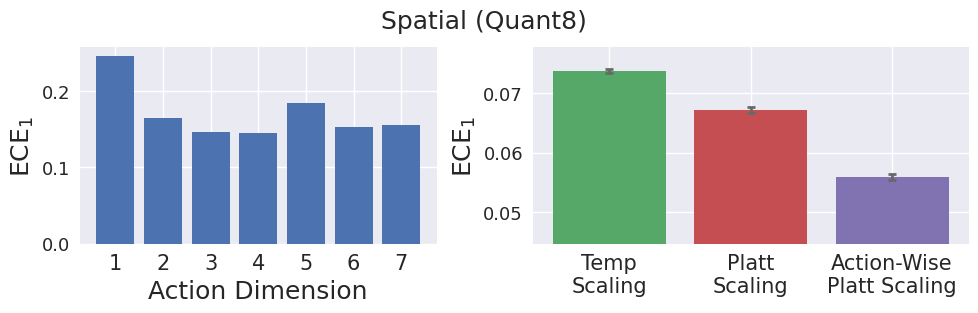

--------------------------------
quant8
--------------------------------
[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_uq/data/scaling_exp_goal_quant8.pkl
base_conf (500, 7)
base_probs (500, 3, 1, 7, 256)
base_logits (500, 3, 1, 7, 256)
ens_conf (500, 7)
ens_probs (500, 3, 20, 7, 256)
ens_logits (500, 3, 20, 7, 256)
---------------------
Base Recalibration


100%|██████████| 1000/1000 [11:33<00:00,  1.44it/s]


uncal ece: 0.13981400000000002 | recal ece: 0.07402900000000001 | action recal ece: 0.06494
temp scale ece: 0.10968400000000002 | action temp scale ece: 0.122903
{'uncal_ece': 0.13981400000000002, 'recal_ece': 0.07402900000000001, 'action_recal_ece': 0.06494, 'temp_scale_ece': 0.10968400000000002, 'action_temp_scale_ece': 0.122903, 'recal_ece_std': 0.022005684697368542, 'action_recal_ece_std': 0.02089388427267654, 'temp_scale_std': 0.012246719724073056, 'action_temp_scale_std': 0.009366514346329697}


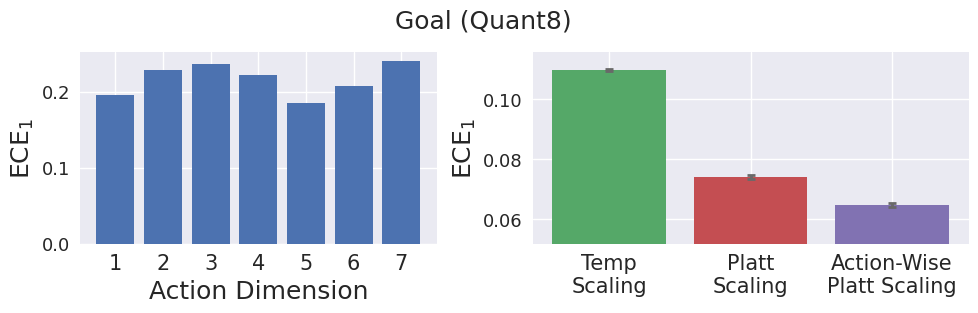

In [9]:
run_exp("spatial", quant="quant8", n_bins=n_bins, test_size=test_size, n_trials=n_trials)
run_exp("goal", quant="quant8", n_bins=n_bins, test_size=test_size, n_trials=n_trials)


--------------------------------
quant4
--------------------------------
[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_uq/data/scaling_exp_spatial_quant4.pkl
base_conf (500, 7)
base_probs (500, 3, 1, 7, 256)
base_logits (500, 3, 1, 7, 256)
ens_conf (500, 7)
ens_probs (500, 3, 20, 7, 256)
ens_logits (500, 3, 20, 7, 256)
---------------------
Base Recalibration


  9%|▊         | 86/1000 [00:25<03:15,  4.67it/s]

100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]


uncal ece: 0.06464800000000001 | recal ece: 0.06513200000000001 | action recal ece: 0.059629
temp scale ece: 0.08004800000000001 | action temp scale ece: 0.08543899999999999
{'uncal_ece': 0.06464800000000001, 'recal_ece': 0.06513200000000001, 'action_recal_ece': 0.059629, 'temp_scale_ece': 0.08004800000000001, 'action_temp_scale_ece': 0.08543899999999999, 'recal_ece_std': 0.018698785415101164, 'action_recal_ece_std': 0.017744614929606106, 'temp_scale_std': 0.013149132899168674, 'action_temp_scale_std': 0.008578710800580702}


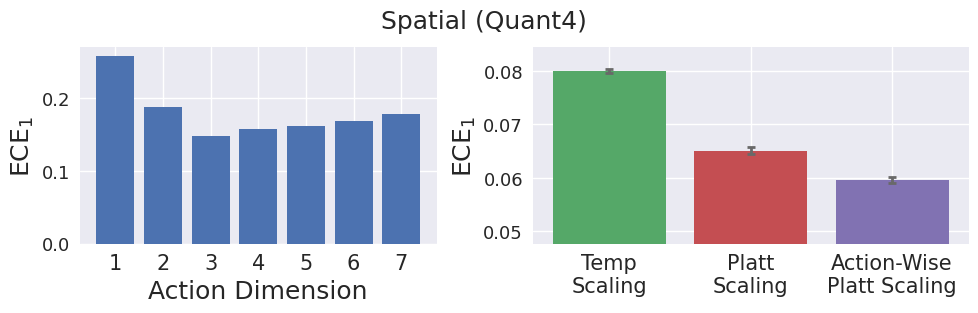

--------------------------------
quant4
--------------------------------
[load_or_create_pickle] Loading existing pickle: /local/zemel/tom/code/vla_uq/data/scaling_exp_goal_quant4.pkl
base_conf (500, 7)
base_probs (500, 3, 1, 7, 256)
base_logits (500, 3, 1, 7, 256)
ens_conf (500, 7)
ens_probs (500, 3, 20, 7, 256)
ens_logits (500, 3, 20, 7, 256)
---------------------
Base Recalibration


100%|██████████| 1000/1000 [11:25<00:00,  1.46it/s]


uncal ece: 0.15750599999999998 | recal ece: 0.084443 | action recal ece: 0.076677
temp scale ece: 0.08546499999999999 | action temp scale ece: 0.09715800000000002
{'uncal_ece': 0.15750599999999998, 'recal_ece': 0.084443, 'action_recal_ece': 0.076677, 'temp_scale_ece': 0.08546499999999999, 'action_temp_scale_ece': 0.09715800000000002, 'recal_ece_std': 0.020971951530556233, 'action_recal_ece_std': 0.019531325377454545, 'temp_scale_std': 0.011679930436436682, 'action_temp_scale_std': 0.00935943566674829}


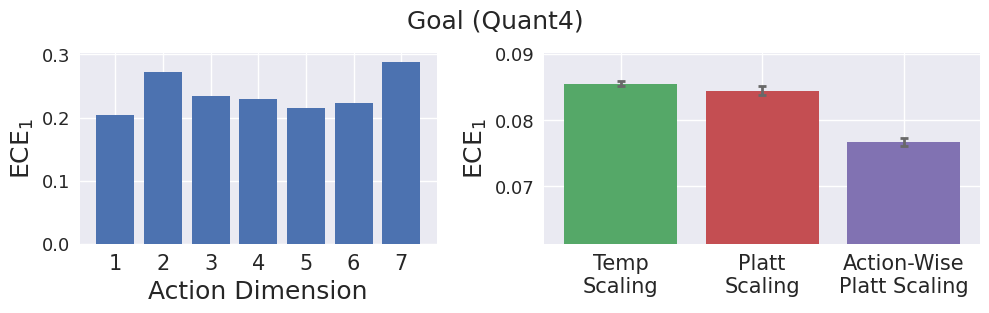

In [10]:
run_exp("spatial", quant="quant4", n_bins=n_bins, test_size=test_size, n_trials=n_trials)
run_exp("goal", quant="quant4", n_bins=n_bins, test_size=test_size, n_trials=n_trials)
